In [1]:
# necessary imports
import matplotlib.pyplot as plt
import cv2
import faiss
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import numpy as np
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.nn.functional as F

from src.detection import augment_image
from src.utils import resize_mask_img, get_dataset_info
from src.backbones import get_model

data_root = "./data"
mvtec_path = f"{data_root}/mvtec_det"
objects, object_anomalies, masking_default, rotation_default = get_dataset_info("MVTec", "informed")

In [2]:
def score_single_image(image_test, image_ref_list, model, masking = True, rotation = True, use_faiss = True):
    features_ref = []

    # Extract reference features and set up the knn index (memory bank)
    for image_ref in image_ref_list:
        if rotation:
            img_augmented = augment_image(image_ref)
        else:
            img_augmented = [image_ref]

        for i in range(len(img_augmented)):
            image_ref = img_augmented[i]
            image_ref_tensor, _ = model.prepare_image(image_ref)
            features_ref_i = model.extract_features(image_ref_tensor)
            features_ref.append(features_ref_i)

    features_ref = np.concatenate(features_ref, axis=0)
    if use_faiss:
        knn_index1 = faiss.IndexFlatL2(features_ref.shape[1])
        faiss.normalize_L2(features_ref)
        knn_index1.add(features_ref)
    else:
        knn_index1 = NearestNeighbors(n_neighbors=1, metric="cosine")
        # normalize features
        features_ref = features_ref / np.linalg.norm(features_ref, axis=1)[:, None]
        knn_index1.fit(features_ref)

    # Extract test features
    image_tensor_test, grid_size2 = model.prepare_image(image_test)
    features_test = model.extract_features(image_tensor_test)

    if use_faiss:
        faiss.normalize_L2(features_test)
        distances, _ = knn_index1.search(features_test, k = 1)
        distances = distances / 2
    else:
        # normalize features
        features_test = features_test / np.linalg.norm(features_test, axis=1)[:, None]
        distances, _ = knn_index1.kneighbors(features_test, n_neighbors=1)
        
    # Filter out the relevant patches of test image
    if masking:
        mask2 = model.compute_background_mask_from_image(image_test, threshold=10, masking_type=masking)
        distances[~mask2] = 0.0
    else:
        mask2 = np.ones(features_test.shape[0], dtype=bool)

    # Compute anomaly score
    score_top1p = np.mean(sorted(distances, reverse = True)[:int(max(1,len(distances) * 0.01))])
    distances = distances.reshape(grid_size2)
    return score_top1p, distances, mask2

In [3]:
class ImprovedSimilarity:
    def __init__(self, feature_dim=384, use_multiscale=True, use_prototype=True):
        self.feature_dim = feature_dim
        self.use_multiscale = use_multiscale
        self.use_prototype = use_prototype

    def multi_scale_similarity(self, features_test, features_ref):
        """多尺度特征相似性计算"""
        #如果不使用多尺度相似度计算
        if not self.use_multiscale:
            #两个特征图余弦相似度计算
            return F.cosine_similarity(features_test, features_ref, dim=1)
        
        similarities = []
        scales = [1, 2, 4]
        
        # 计算实际的空间尺寸
        num_patches = features_test.shape[0]
        spatial_size = int(np.sqrt(num_patches))
        
        if spatial_size * spatial_size != num_patches:
            spatial_size = int(np.ceil(np.sqrt(num_patches)))
            print(f"Warning: 特征数量 {num_patches} 不是完美平方数，使用空间尺寸 {spatial_size}x{spatial_size}")
        
        for scale in scales:
            if scale > 1:
                # 重塑为2D特征图格式
                feat_test_2d = features_test.reshape(-1, spatial_size, spatial_size, self.feature_dim)
                feat_ref_2d = features_ref.reshape(-1, spatial_size, spatial_size, self.feature_dim)
                
                # 调整维度以适应池化操作 (batch, channels, height, width)
                feat_test_scaled = F.avg_pool2d(
                    feat_test_2d.permute(0, 3, 1, 2), 
                    kernel_size=scale
                ).permute(0, 2, 3, 1)
                feat_ref_scaled = F.avg_pool2d(
                    feat_ref_2d.permute(0, 3, 1, 2), 
                    kernel_size=scale
                ).permute(0, 2, 3, 1)
                
                # 重新展平为特征向量
                feat_test_scaled = feat_test_scaled.reshape(-1, self.feature_dim)
                feat_ref_scaled = feat_ref_scaled.reshape(-1, self.feature_dim)
            else:
                # 1x1尺度直接使用原始特征
                feat_test_scaled = features_test
                feat_ref_scaled = features_ref
            
            # 归一化并计算相似度矩阵
            feat_test_norm = F.normalize(feat_test_scaled, p=2, dim=1)
            feat_ref_norm = F.normalize(feat_ref_scaled, p=2, dim=1)
            similarity_matrix = torch.matmul(feat_test_norm, feat_ref_norm.T)
            max_similarity, _ = similarity_matrix.max(dim=1)
            similarities.append(max_similarity)
        
        # 处理不同尺度下的长度不一致问题
        if similarities:
            min_len = min(len(s) for s in similarities)
            similarities = [s[:min_len] for s in similarities]
            max_similarity = torch.stack(similarities).mean(dim=0)
        else:
            max_similarity = torch.tensor([])

        #将max_similarity扩展到2025，与其他距离size一样
        if max_similarity.shape[0] < 2025:
            max_similarity = F.interpolate(max_similarity.view(1,1,-1,1), size=(2025, 1), mode='nearest').view(-1)

        return max_similarity

    def prototype_similarity(self, features_test, features_ref, n_prototypes=5):
        """基于原型的相似性计算"""
        if not self.use_prototype or len(features_ref) <= n_prototypes:
            distances = torch.cdist(features_test, features_ref)
            return distances.min(dim=1)[0]
        
        # 使用KMeans聚类生成原型
        kmeans = KMeans(n_clusters=min(n_prototypes, len(features_ref)), random_state=0)
        kmeans.fit(features_ref.cpu().numpy())
        prototypes = torch.tensor(
            kmeans.cluster_centers_, 
            dtype=torch.float32, 
            device=features_test.device
        )
        
        # 计算到原型的最小距离
        distances = torch.cdist(features_test, prototypes)
        return distances.min(dim=1)[0]

    def multi_metric_fusion(self, features_test, features_ref):
        """多度量融合方法"""
        # 1. 余弦距离
        feat_test_norm = F.normalize(features_test, p=2, dim=1)
        feat_ref_norm = F.normalize(features_ref, p=2, dim=1)
        cosine_sim = torch.matmul(feat_test_norm, feat_ref_norm.T)
        cosine_dist = 1 - cosine_sim.max(dim=1)[0]
        
        # 2. 最近邻距离
        distances = torch.cdist(features_test, features_ref)
        nn_dist = distances.min(dim=1)[0]
        
        # 3. 原型距离
        proto_dist = self.prototype_similarity(features_test, features_ref)
        
        # 4. 多尺度距离
        multi_scale_sim = self.multi_scale_similarity(features_test, features_ref)
        multi_scale_dist = 1 - multi_scale_sim

        # 加权融合（这里包含了多尺度距离的权重）
        weights = [0.25, 0.25, 0.25, 0.25]  # 调整为四个度量的权重
        final_distance = (weights[0] * cosine_dist +
                          weights[1] * nn_dist +
                          weights[2] * proto_dist +
                          weights[3] * multi_scale_dist)
        
        return final_distance

In [4]:
def score_single_image_improved(image_test, image_ref_list, model, masking = True, rotation = True, use_faiss = True):
    """改进的异常检测函数"""
    features_ref = []
    similarity_calculator = ImprovedSimilarity()

    # 提取参考特征
    for image_ref in image_ref_list:
        if rotation:
            img_augmented = augment_image(image_ref)
        else:
            img_augmented = [image_ref]

        for img in img_augmented:
            image_tensor, _ = model.prepare_image(img)
            features_np = model.extract_features(image_tensor)
            features_tensor = torch.from_numpy(features_np).float()
            features_ref.append(features_tensor)

    # 拼接参考特征
    # features_ref = torch.cat(features_ref, dim=0)
    features_ref = np.concatenate(features_ref, axis=0)

    if use_faiss:
        knn_index1 = faiss.IndexFlatL2(features_ref.shape[1])
        faiss.normalize_L2(features_ref)
        knn_index1.add(features_ref)
    else:
        knn_index1 = NearestNeighbors(n_neighbors=1, metric="cosine")
        # normalize features
        features_ref = features_ref / np.linalg.norm(features_ref, axis=1)[:, None]
        knn_index1.fit(features_ref)

    # 提取测试特征
    # image_tensor_test, grid_size2 = model.prepare_image(image_test)
    # features_test_np = model.extract_features(image_tensor_test)
    # features_test = torch.from_numpy(features_test_np).float()
    image_tensor_test, grid_size2 = model.prepare_image(image_test)
    features_test = model.extract_features(image_tensor_test)

    if use_faiss:
        faiss.normalize_L2(features_test)
        distances, _ = knn_index1.search(features_test, k = 1)
        distances = distances / 2
    else:
        # normalize features
        features_test = features_test / np.linalg.norm(features_test, axis=1)[:, None]
        distances, _ = knn_index1.kneighbors(features_test, n_neighbors=1)

    #将numpy.ndarray类型转换为tensor张量
    features_test_tensor = torch.tensor(features_test)
    features_ref_tensor = torch.tensor(features_ref)

    # 计算距离
    distances = similarity_calculator.multi_metric_fusion(features_test_tensor, features_ref_tensor)

    # 过滤背景区域
    if masking:
        # 确保masking_type有有效值
        masking_type = masking if masking is not None else "default"
        mask2 = model.compute_background_mask_from_image(
            image_test, 
            threshold=10, 
            masking_type=masking_type
        )
        # 确保mask与特征尺寸匹配
        if len(mask2) > len(distances):
            mask2 = mask2[:len(distances)]
        elif len(mask2) < len(distances):
            mask2 = np.pad(mask2, (0, len(distances)-len(mask2)), mode='constant')
        distances[~mask2] = 0.0
    else:
        mask2 = np.ones(features_test.shape[0], dtype=bool)

    # 计算异常分数
    valid_distances = distances[mask2]
    if len(valid_distances) > 0:
        score_top1p = torch.mean(torch.sort(valid_distances)[0][-int(max(1, len(valid_distances) * 0.01)):]).item()
    else:
        score_top1p = 0.0
        
    distances_reshaped = distances.reshape(grid_size2).numpy()
    return score_top1p, distances_reshaped, mask2

In [5]:
# Load DINOv2 model
model = get_model('dinov2_vits14', 'cuda', smaller_edge_size=32*20)

Loading model: dinov2_vits14
Device: cuda
Smaller edge size: 640


Using cache found in /home/zhujiang/.cache/torch/hub/facebookresearch_dinov2_main
/home/zhujiang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/zhujiang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/zhujiang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


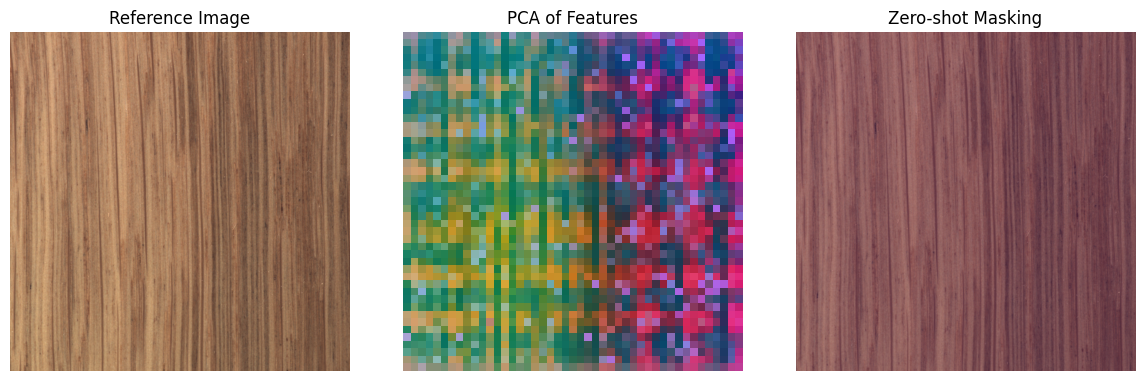

In [6]:
# Load reference image
object_name = "wood" # change object/image as you like
img_name = "001.png"
image_ref = cv2.imread(f"{mvtec_path}/{object_name}/train/good/{img_name}")
image_ref = cv2.cvtColor(image_ref, cv2.COLOR_BGR2RGB)

masking = masking_default[object_name] # set masking = False for textures

# Compute features and mask
image_tensor1, grid_size1 = model.prepare_image(image_ref)
features_ref = model.extract_features(image_tensor1)
mask_ref = model.compute_background_mask(features_ref, grid_size1, threshold=10, masking_type=masking)
vis_image_ref = model.get_embedding_visualization(features_ref, grid_size1)

# Visualization: 1 = clean reference image, 2 = PCA-dimensions (top 3) of features, 3 = zero-shot masking (PCA[0] > 10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(image_ref)
ax2.imshow(vis_image_ref)
resized_mask = resize_mask_img(mask_ref, image_ref.shape, grid_size1)
ax3.imshow(image_ref)
# prepare_mask
ax3.imshow(resize_mask_img(mask_ref, image_ref.shape, grid_size1), alpha=0.3)
# ax3.imshow(model.prepare_mask(mask_ref, image_ref.shape, grid_size1), alpha=0.3)
fig.tight_layout()
ax1.axis('off')
ax1.set_title("Reference Image")
ax2.axis('off')
ax2.set_title("PCA of Features")
ax3.axis('off')
ax3.set_title("Zero-shot Masking")
plt.show()

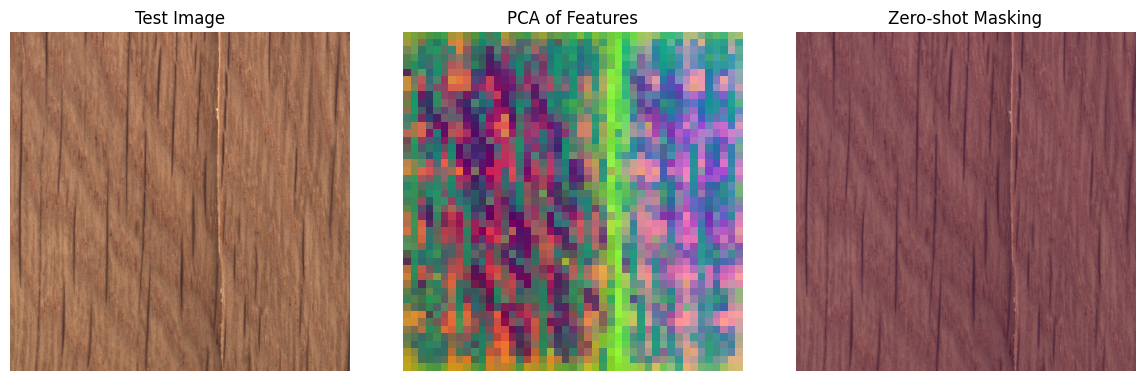

In [7]:
# Load test image
anomaly_type = "scratch" # "good", "crack", "hole"... (depends on the object/product)
test_img_name = "001.png"

# Load test image from given anomaly type
image_test_path = f"{mvtec_path}/{object_name}/test/{anomaly_type}/{test_img_name}"
image_test = cv2.cvtColor(cv2.imread(image_test_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

# Compute features and mask
image_tensor2, grid_size2 = model.prepare_image(image_test)
features_test = model.extract_features(image_tensor2)
mask_test = model.compute_background_mask(features_test, grid_size2, threshold=10, masking_type=masking)
vis_image_test = model.get_embedding_visualization(features_test, grid_size2)

# Visualization: 1 = clean reference image, 2 = PCA-dimensions (top 3) of features, 3 = zero-shot masking (PCA[0] > 10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(image_test)
ax2.imshow(vis_image_test)
resized_mask = resize_mask_img(mask_test, image_test.shape, grid_size2)
ax3.imshow(image_test)
ax3.imshow(resize_mask_img(mask_test, image_test.shape, grid_size2), alpha=0.3)

fig.tight_layout()
ax1.axis('off')
ax1.set_title("Test Image")
ax2.axis('off')
ax2.set_title("PCA of Features")
ax3.axis('off')
ax3.set_title("Zero-shot Masking")
plt.show()

## Score the test image

In [8]:
# read in k reference images (k-shot)
k = 4
image_ref_list = []

for i in range(k):
    image_ref_path = f"{mvtec_path}/{object_name}/train/good/{i+1:03d}.png"
    image_ref = cv2.cvtColor(cv2.imread(image_ref_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    image_ref_list.append(image_ref)

In [9]:
anomaly_score, patch_distances, mask_test = score_single_image(image_test, image_ref_list, model, masking = masking, rotation = False, use_faiss = True)
print(f"The predict anomaly score ({k}-shot) for this sample is ", anomaly_score)

The predict anomaly score (4-shot) for this sample is  0.37602884


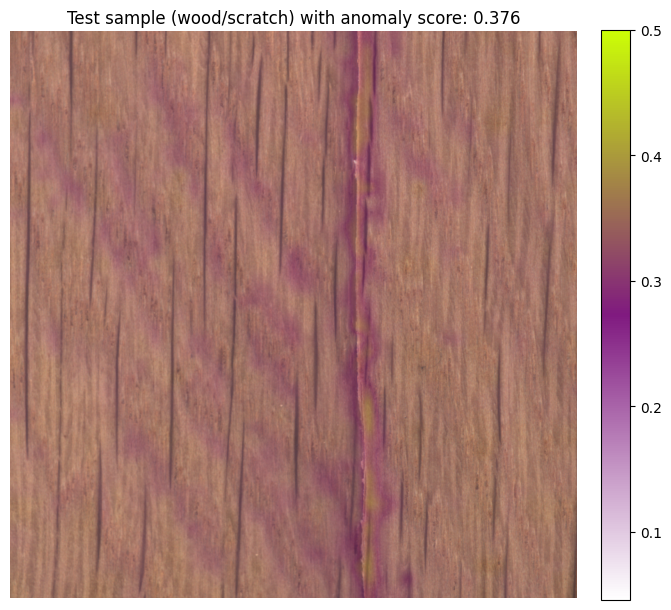

In [10]:
# plot anomaly map
from  matplotlib.colors import LinearSegmentedColormap
neon_violet = (0.5, 0.1, 0.5, 0.4)
neon_yellow = (0.8, 1.0, 0.02, 0.7)
colors = [(1.0, 1, 1.0, 0.0),  neon_violet, neon_yellow]
cmap = LinearSegmentedColormap.from_list("AnomalyMap", colors, N=256)

plt.figure(figsize=(8, 8))
plt.imshow(image_test, alpha=1.0)

d = patch_distances.flatten()
d = cv2.resize(d.reshape(grid_size2), (image_test.shape[1], image_test.shape[0]), interpolation = cv2.INTER_LINEAR)
d = gaussian_filter(d, sigma=4.0)
vmax = 0.5 # vmax may need to be adjusted differently for different objects, for hazelnut 0.5 is a good choice
plt.colorbar(plt.imshow(d, alpha=1.0, cmap=cmap, vmax=vmax), orientation='vertical', fraction=0.046, pad=0.04)

plt.axis('off')
plt.title(f"Test sample ({object_name}/{anomaly_type}) with anomaly score: {anomaly_score:.3f}")
plt.show()

In [11]:
anomaly_score, patch_distances, mask_test = score_single_image_improved(image_test, image_ref_list, model, masking = masking, rotation = False)
print(f"The improve predict anomaly score ({k}-shot) for this sample is ", anomaly_score)

The improve predict anomaly score (4-shot) for this sample is  0.5676974058151245


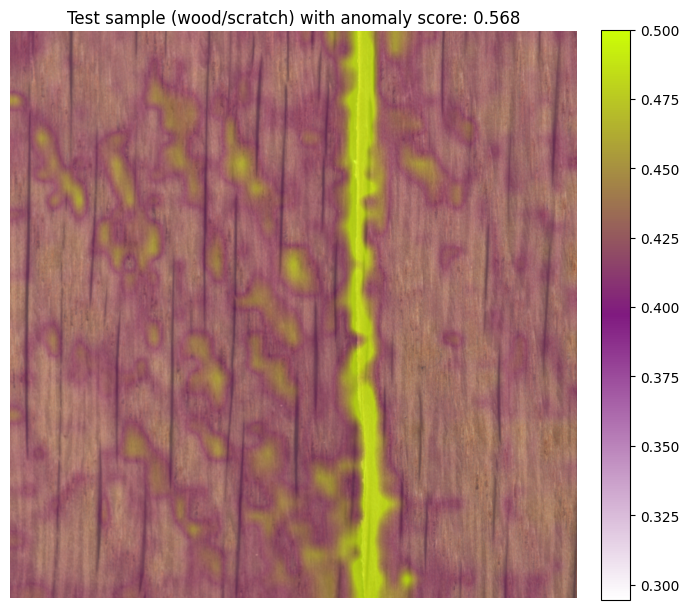

In [12]:
# plot anomaly map
from  matplotlib.colors import LinearSegmentedColormap
neon_violet = (0.5, 0.1, 0.5, 0.4)
neon_yellow = (0.8, 1.0, 0.02, 0.7)
colors = [(1.0, 1, 1.0, 0.0),  neon_violet, neon_yellow]
cmap = LinearSegmentedColormap.from_list("AnomalyMap", colors, N=256)

plt.figure(figsize=(8, 8))
plt.imshow(image_test, alpha=1.0)

d = patch_distances.flatten()
d = cv2.resize(d.reshape(grid_size2), (image_test.shape[1], image_test.shape[0]), interpolation = cv2.INTER_LINEAR)
d = gaussian_filter(d, sigma=4.0)
vmax = 0.5 # vmax may need to be adjusted differently for different objects, for hazelnut 0.5 is a good choice
plt.colorbar(plt.imshow(d, alpha=1.0, cmap=cmap, vmax=vmax), orientation='vertical', fraction=0.046, pad=0.04)

plt.axis('off')
plt.title(f"Test sample ({object_name}/{anomaly_type}) with anomaly score: {anomaly_score:.3f}")
plt.show()